In [6]:
# Necessary utility modules and libraries
import os
import shutil
import pathlib
import random
import datetime
import cv2
    
# Plotting libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.signal import gaussian, convolve2d
import seaborn as sns

# Libraries for building the model
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, MaxPool2D, Dropout, Activation, GlobalAveragePooling2D, BatchNormalization, GlobalMaxPooling2D
from tensorflow.keras.applications import DenseNet121, ResNet50, InceptionV3, Xception, VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend
from tensorflow.keras.regularizers import l2, l1
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score, confusion_matrix

Data Loading and Pre-processing

In [2]:
classes = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']

In [4]:
dir_path = 'D:\Project\BioHack\dataset\eyepacs_preprocess\eyepacs_preprocess'
os.listdir(dir_path)

['10003_left.jpeg',
 '10003_right.jpeg',
 '10007_left.jpeg',
 '10007_right.jpeg',
 '10009_left.jpeg',
 '10009_right.jpeg',
 '1000_left.jpeg',
 '1000_right.jpeg',
 '10010_left.jpeg',
 '10010_right.jpeg',
 '10013_left.jpeg',
 '10013_right.jpeg',
 '10014_left.jpeg',
 '10014_right.jpeg',
 '10015_left.jpeg',
 '10015_right.jpeg',
 '10017_left.jpeg',
 '10017_right.jpeg',
 '10022_left.jpeg',
 '10022_right.jpeg',
 '10028_left.jpeg',
 '10028_right.jpeg',
 '10029_left.jpeg',
 '10029_right.jpeg',
 '1002_left.jpeg',
 '1002_right.jpeg',
 '10030_left.jpeg',
 '10030_right.jpeg',
 '10031_left.jpeg',
 '10031_right.jpeg',
 '10032_left.jpeg',
 '10032_right.jpeg',
 '10035_left.jpeg',
 '10035_right.jpeg',
 '10042_left.jpeg',
 '10042_right.jpeg',
 '10043_left.jpeg',
 '10043_right.jpeg',
 '10046_left.jpeg',
 '10046_right.jpeg',
 '10047_left.jpeg',
 '10047_right.jpeg',
 '10048_left.jpeg',
 '10048_right.jpeg',
 '10050_left.jpeg',
 '10050_right.jpeg',
 '10053_left.jpeg',
 '10053_right.jpeg',
 '10058_left.jpeg',


In [8]:
df_temp = pd.read_csv("D:/Project/BioHack/dataset/eyepacs_preprocess/trainLabels.csv")

In [9]:
len(df_temp), df_temp

(35108,
              image  level
 0          10_left      0
 1         10_right      0
 2          13_left      0
 3         13_right      0
 4          15_left      1
 ...            ...    ...
 35103  44347_right      0
 35104   44348_left      0
 35105  44348_right      0
 35106   44349_left      0
 35107  44349_right      1
 
 [35108 rows x 2 columns])

In [10]:
df_temp['level'].value_counts()

0    25802
2     5288
1     2438
3      872
4      708
Name: level, dtype: int64

In [11]:
class_code = {0: "No_DR",
              1: "Mild", 
              2: "Moderate",
              3: "Severe",
              4: "Proliferate_DR"}
df_temp.rename(columns={"image": "id_code", "level": "diagnosis"}, inplace=True)

In [12]:
def mapping_temp(df, root=dir_path):
    class_code = {0: "No_DR",
                  1: "Mild", 
                  2: "Moderate",
                  3: "Severe",
                  4: "Proliferate_DR"}
    df['label'] = list(map(class_code.get, df['diagnosis']))
    df['path'] = [i[1]['label']+'/'+i[1]['id_code']+'.jpeg' for i in df.iterrows()]
    return df

df_temp = mapping_temp(df_temp)
df_temp

id_code  diagnosis  label                    path
0          10_left          0  No_DR      No_DR/10_left.jpeg
1         10_right          0  No_DR     No_DR/10_right.jpeg
2          13_left          0  No_DR      No_DR/13_left.jpeg
3         13_right          0  No_DR     No_DR/13_right.jpeg
4          15_left          1   Mild       Mild/15_left.jpeg
...            ...        ...    ...                     ...
35103  44347_right          0  No_DR  No_DR/44347_right.jpeg
35104   44348_left          0  No_DR   No_DR/44348_left.jpeg
35105  44348_right          0  No_DR  No_DR/44348_right.jpeg
35106   44349_left          0  No_DR   No_DR/44349_left.jpeg
35107  44349_right          1   Mild   Mild/44349_right.jpeg

[35108 rows x 4 columns]

In [13]:
# Dropping the diagnosis column because the model assigns different codes for prediction
df_temp.drop(['diagnosis'], axis=1, inplace=True)

In [14]:
df_temp

id_code  label                    path
0          10_left  No_DR      No_DR/10_left.jpeg
1         10_right  No_DR     No_DR/10_right.jpeg
2          13_left  No_DR      No_DR/13_left.jpeg
3         13_right  No_DR     No_DR/13_right.jpeg
4          15_left   Mild       Mild/15_left.jpeg
...            ...    ...                     ...
35103  44347_right  No_DR  No_DR/44347_right.jpeg
35104   44348_left  No_DR   No_DR/44348_left.jpeg
35105  44348_right  No_DR  No_DR/44348_right.jpeg
35106   44349_left  No_DR   No_DR/44349_left.jpeg
35107  44349_right   Mild   Mild/44349_right.jpeg

[35108 rows x 3 columns]

In [15]:
# wiener filter
def wiener_filter(img, kernel, K):
    kernel /= np.sum(kernel)
    dummy = np.copy(img)
    dummy = np.fft.fft2(dummy)
    kernel = np.fft.fft2(kernel, s = img.shape)
    kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
    dummy = dummy * kernel
    dummy = np.abs(np.fft.ifft2(dummy))
    return dummy

def gaussian_kernel(kernel_size = 3):
    h = gaussian(kernel_size, kernel_size / 3).reshape(kernel_size, 1)
    h = np.dot(h, h.transpose())
    h /= np.sum(h)
    return h

def isbright(image, dim=227, thresh=0.4):
    # Resize image to 10x10
    image = cv2.resize(image, (dim, dim))
    # Convert color space to LAB format and extract L channel
    L, A, B = cv2.split(cv2.cvtColor(image, cv2.COLOR_BGR2LAB))
    # Normalize L channel by dividing all pixel values with maximum pixel value
    L = L/np.max(L)
    # Return True if mean is greater than thresh else False
    return np.mean(L) > thresh

In [16]:
def image_preprocessing(img):
    # 1. Read the image
#     img = mpimg.imread(img_path)
    img = img.astype(np.uint8)
    
    # 2. Extract the green channel of the image
    b, g, r = cv2.split(img)
    
    # 3.1. Apply CLAHE to intensify the green channel extracted image
    clh = cv2.createCLAHE(clipLimit=4.0)
    g = clh.apply(g)
    
    # 3.2. Convert enhanced image to grayscale
    merged_bgr_green_fused = cv2.merge((b, g, r))
    img_bw = cv2.cvtColor(merged_bgr_green_fused, cv2.COLOR_BGR2GRAY)
    
    # 4. Remove the isolated pixels using morphological cleaning operation.
    kernel1 = np.ones((1, 1), np.uint8)
    morph_open = cv2.morphologyEx(img_bw, cv2.MORPH_OPEN, kernel1)
    
    # 5. Extract blood vessels using mean-C thresholding.
    thresh = cv2.adaptiveThreshold(morph_open, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 9, 5)
    
    # 6. Applying morph_open operation
    kernel2 = np.ones((2, 2), np.uint8)
    morph_open2 = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel2)
    
    # 6. Stacking the image into 3 channels
    stacked_img = np.stack((morph_open2,)*3, axis=-1)
    
    return stacked_img.astype("float64")

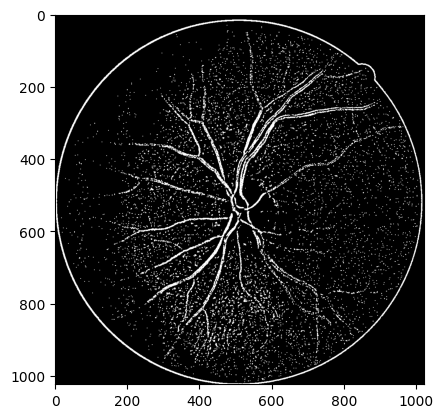

In [18]:
p = "D:/Project/BioHack/dataset/eyepacs_preprocess/eyepacs_preprocess/10_left.jpeg"
img = mpimg.imread(p)
pro = image_preprocessing(img)
filename = os.path.basename(p)
plt.imshow(pro.astype("uint8"), cmap="gray");
# cv2.imwrite(filename, pro)
# plt.imshow(img)

In [19]:
random_img_path = [dir_path+'/'+img for img in random.sample(os.listdir(dir_path), 50)]
random_img_path

['D:\\Project\\BioHack\\dataset\\eyepacs_preprocess\\eyepacs_preprocess/12577_right.jpeg',
 'D:\\Project\\BioHack\\dataset\\eyepacs_preprocess\\eyepacs_preprocess/5471_left.jpeg',
 'D:\\Project\\BioHack\\dataset\\eyepacs_preprocess\\eyepacs_preprocess/12129_right.jpeg',
 'D:\\Project\\BioHack\\dataset\\eyepacs_preprocess\\eyepacs_preprocess/33144_left.jpeg',
 'D:\\Project\\BioHack\\dataset\\eyepacs_preprocess\\eyepacs_preprocess/16189_left.jpeg',
 'D:\\Project\\BioHack\\dataset\\eyepacs_preprocess\\eyepacs_preprocess/35277_right.jpeg',
 'D:\\Project\\BioHack\\dataset\\eyepacs_preprocess\\eyepacs_preprocess/10954_left.jpeg',
 'D:\\Project\\BioHack\\dataset\\eyepacs_preprocess\\eyepacs_preprocess/11149_right.jpeg',
 'D:\\Project\\BioHack\\dataset\\eyepacs_preprocess\\eyepacs_preprocess/8153_right.jpeg',
 'D:\\Project\\BioHack\\dataset\\eyepacs_preprocess\\eyepacs_preprocess/24706_right.jpeg',
 'D:\\Project\\BioHack\\dataset\\eyepacs_preprocess\\eyepacs_preprocess/10495_left.jpeg',
 'D:\\

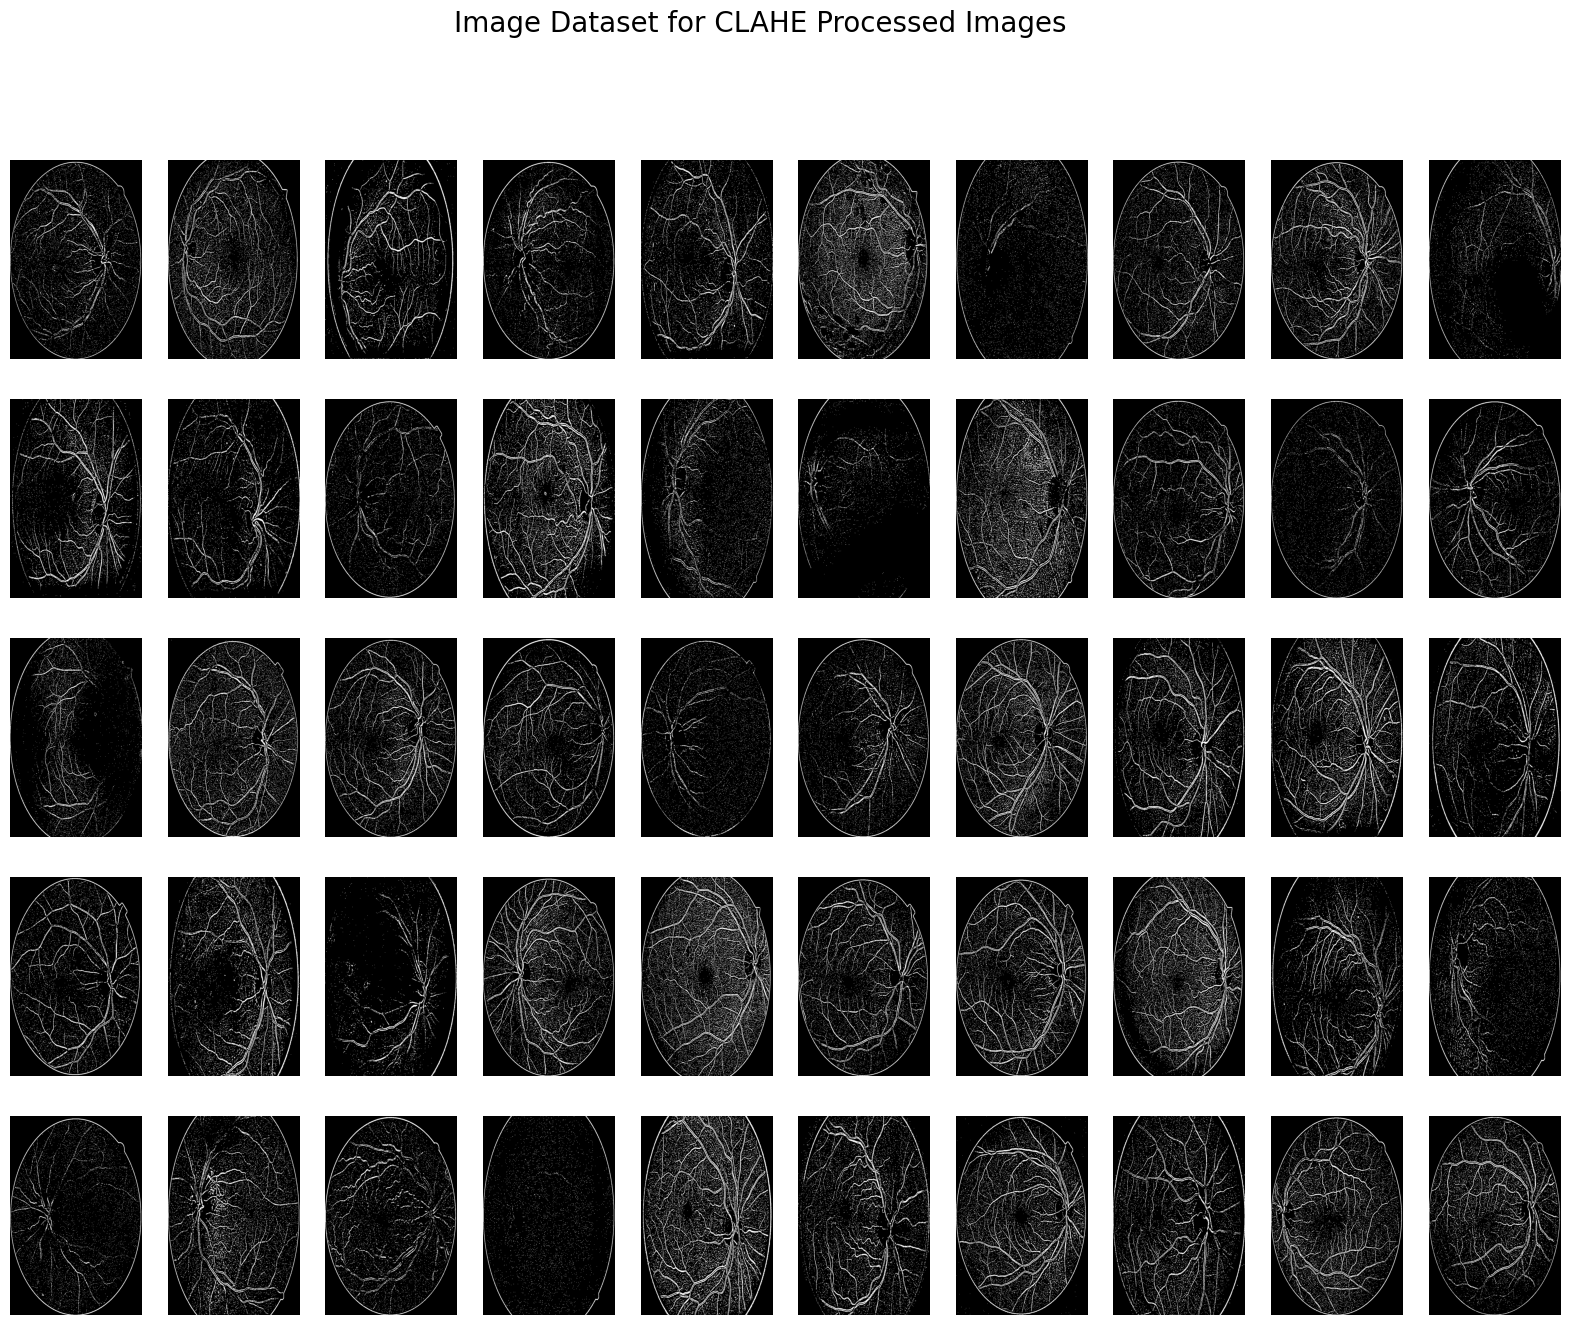

In [20]:
plt.figure(figsize=(20, 15))
plt.suptitle("Image Dataset for CLAHE Processed Images", fontsize=20)

for i in range(1, 51):
    plt.subplot(5, 10, i)
    img = mpimg.imread(random_img_path[i-1])
    img_pro = image_preprocessing(img)
    plt.imshow(img_pro.astype("uint8"), cmap="gray", aspect="auto")
    plt.axis(False);

In [21]:
for i in range(5):
    os.mkdir('./'+class_code[i])

In [22]:
import os
import shutil
# for i in df_temp.iloc[:5, :].iterrows():
#     print(i[1][2])
res = [[i[1][1], i[1][2]] for i in df_temp.iterrows()]
for i in res:
    des = './'+i[0]+'/'
    src = dir_path+'/'+i[1].split('/')[1]
    shutil.copy(src, des)

In [23]:
# The model assigns labels in ascending order
classes = sorted(classes)
classes

['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']

In [24]:
train_df_temp = {}
test_df_temp = {}
for i in range(5):
    df = df_temp[df_temp['label']==classes[i]]['id_code'].to_list()
    random.seed(42)
    x = random.sample(df, int(0.8*len(df)))
    for j in x:
        train_df_temp[j] = i
    for j in df:
        if j not in train_df_temp.keys():
            test_df_temp[j] = i
train_df_temp = pd.DataFrame(train_df_temp.items(), columns=['id_code', 'diagnosis']).sample(frac=1, random_state=42)
test_df_temp = pd.DataFrame(test_df_temp.items(), columns=['id_code', 'diagnosis']).sample(frac=1, random_state=42)
train_df_temp

id_code  diagnosis
17599   29303_left          2
5676    29857_left          1
10356   33818_left          2
9463   25402_right          2
428    12990_right          0
...            ...        ...
21575   30586_left          2
5390    11270_left          1
860    27360_right          0
15795  44188_right          2
23654   40793_left          2

[28084 rows x 2 columns]

In [25]:
class_code = {0: "Mild",
              1: "Moderate", 
              2: "No_DR",
              3: "Proliferate_DR",
              4: "Severe"}
train_df_temp['label'] = list(map(class_code.get, train_df_temp['diagnosis']))
train_df_temp['path'] = [i[1]['label']+'/'+i[1]['id_code']+'.jpeg' for i in train_df_temp.iterrows()]
test_df_temp['label'] = list(map(class_code.get, test_df_temp['diagnosis']))
test_df_temp['path'] = [i[1]['label']+'/'+i[1]['id_code']+'.jpeg' for i in test_df_temp.iterrows()]

In [26]:
# Initializing the input size
IMG_SHAPE = (224, 224)
N_SPLIT = 3
EPOCHS = 10

In [27]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   preprocessing_function = image_preprocessing)
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                        preprocessing_function = image_preprocessing)

train_data = train_datagen.flow_from_dataframe(dataframe=train_df_temp, 
                                               directory='./',
                                               x_col='path',
                                               y_col='label',
                                               class_mode="categorical",
                                               batch_size=32,
                                               seed=42,
                                               target_size=IMG_SHAPE)

valid_data = validation_datagen.flow_from_dataframe(dataframe=test_df_temp, 
                                                   directory='./',
                                                   x_col='path',
                                                   y_col='label',
                                                   class_mode="categorical",
                                                   batch_size=32, 
                                                   seed=42, 
                                                   target_size=IMG_SHAPE)

# Initializing the early stopping callback
es = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)

Found 28084 validated image filenames belonging to 5 classes.
Found 7024 validated image filenames belonging to 5 classes.


Evaluation metric helper functions

In [31]:
def cm(y_true, y_pred):
    classes.sort()
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm,
                     index = classes, 
                     columns = classes)
    #Plotting the confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()

def metrics(y_true, y_pred):
#     print(classification_report(y_true, y_pred, target_names=classes))
    acc = accuracy_score(y_true, y_pred)
    res = []
    for l in [0,1,2,3,4]:
        prec,recall,_,_ = precision_recall_fscore_support(np.array(y_true)==l,
                                                          np.array(y_pred)==l,
                                                          pos_label=True,
                                                          average=None)
        res.append([classes[l],recall[0],recall[1]])
    df_res = pd.DataFrame(res,columns = ['class','sensitivity','specificity'])
    return df_res, acc

In [32]:
# Function to train model
def train_model(model_test, epochs=EPOCHS, lr=0.001): 
    # Compile the model
    model_test.compile(loss='categorical_crossentropy',
                      optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                      metrics=['accuracy'])

    history = model_test.fit(train_data,
                           validation_data=valid_data,
                           steps_per_epoch=int(0.2* int(train_data.n//train_data.batch_size)),
                           epochs=epochs,
                           validation_steps=int(valid_data.n//valid_data.batch_size),
                           callbacks=[es])
    return history.history

# Function to make predictions on the test data
def make_predictions(model_test):
    # Evaluate the model
    predictions = model_test.predict(valid_data, verbose=1)
    y_preds = np.argmax(predictions, axis=1)
    return y_preds

In [33]:
# Function to plot the performance metrics
def plot_result(hist):
    plt.figure(figsize=(20, 10));
    plt.suptitle(f"Performance Metrics", fontsize=20)
    
    # Actual and validation losses
    plt.subplot(1, 2, 1);
    plt.plot(hist['loss'], label='train')
    plt.plot(hist['val_loss'], label='validation')
    plt.title('Train and val loss curve')
    plt.legend()

    # Actual and validation accuracy
    plt.subplot(1, 2, 2);
    plt.plot(hist['accuracy'], label='train')
    plt.plot(hist['val_accuracy'], label='validation')
    plt.title('Train and val accuracy curve')
    plt.legend()

In [34]:
# View random images in the dataset
def view_random_images(root_dir, classes=classes):
    class_paths = [root_dir + "/" + image_class for image_class in classes]
    # print(class_paths)
    images_path = []
    labels = []
    for i in range(len(class_paths)):
        random_images = random.sample(os.listdir(class_paths[i]), 10)
        random_images_path = [class_paths[i]+'/'+img for img in random_images]
        for j in random_images_path:
            images_path.append(j)
            labels.append(classes[i])
    images_path

    plt.figure(figsize=(17, 10))
    plt.suptitle("Image Dataset", fontsize=20)

    for i in range(1, 51):
        plt.subplot(5, 10, i)
        img = mpimg.imread(images_path[i-1])
        plt.imshow(img, aspect="auto")
        plt.title(labels[i-1])
        plt.axis(False);

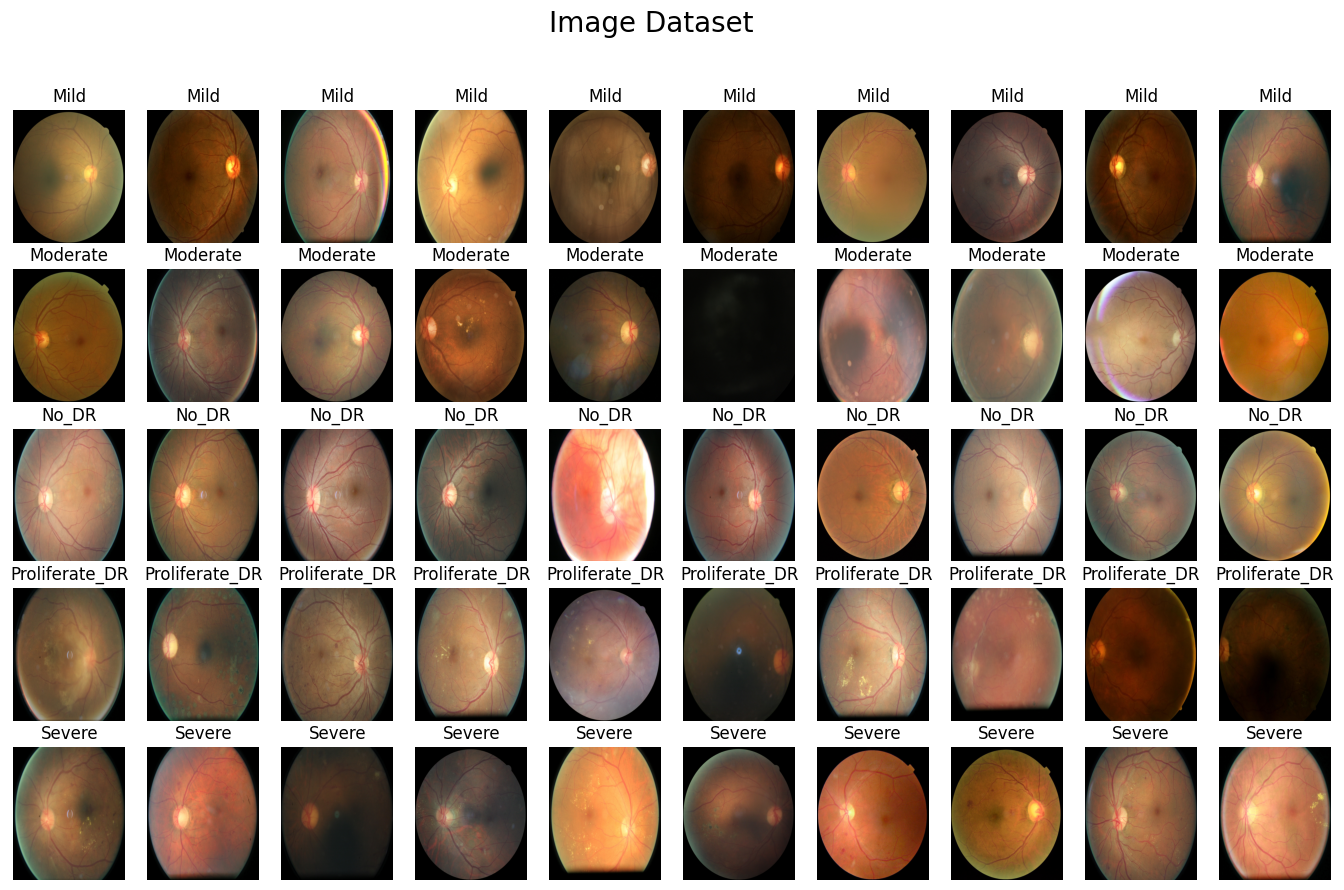

In [35]:
# Observing the images
view_random_images(root_dir='./')

Modelling (base Models)
We'll use the following ImageNet models for training the images and observe the variations of the accuracy of the predicitions as predicted by the models:

AlexNet
DenseNet121
ResNet50

1. AlexNet

In [36]:
# Basic CNN model for AlexNet
model_alexnet = tf.keras.Sequential([
    Conv2D(input_shape=IMG_SHAPE+(3,), filters=96,kernel_size=11,strides=4,activation='relu'),
    MaxPool2D(pool_size=3,strides=2),
    Conv2D(filters=256,kernel_size=5,strides=1,padding='valid',activation='relu'),
    MaxPool2D(pool_size=3,strides=2),
    Conv2D(filters=384,kernel_size=3,strides=1,padding='same',activation='relu'),
    Conv2D(filters=384,kernel_size=3,strides=1,padding='same',activation='relu'),
    Conv2D(filters=256,kernel_size=3,strides=1,padding='same',activation='relu'),
    MaxPool2D(pool_size=3,strides=2),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dropout(0.5),
    Flatten(),
    Dense(len(classes), activation='softmax')
], name="model_AlexNet")

In [37]:
# Summary of AlexNet model
model_alexnet.summary()

Model: "model_AlexNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 384)     

In [38]:
model_alexnet_history = train_model(model_alexnet)

Epoch 1/10
175/175 [==============================] - 285s 2s/step - loss: 0.9440 - accuracy: 0.7257 - val_loss: 0.8764 - val_accuracy: 0.7349
Epoch 2/10
175/175 [==============================] - 277s 2s/step - loss: 0.8865 - accuracy: 0.7304 - val_loss: 0.8707 - val_accuracy: 0.7349
Epoch 3/10
175/175 [==============================] - 279s 2s/step - loss: 0.8523 - accuracy: 0.7454 - val_loss: 0.8737 - val_accuracy: 0.7349
Epoch 4/10
175/175 [==============================] - 271s 2s/step - loss: 0.8688 - accuracy: 0.7357 - val_loss: 0.8792 - val_accuracy: 0.7350
Epoch 5/10
175/175 [==============================] - 272s 2s/step - loss: 0.8776 - accuracy: 0.7343 - val_loss: 0.8746 - val_accuracy: 0.7349
Epoch 6/10
175/175 [==============================] - 270s 2s/step - loss: 0.8785 - accuracy: 0.7319 - val_loss: 0.8695 - val_accuracy: 0.7350
Epoch 7/10
175/175 [==============================] - 273s 2s/step - loss: 0.8739 - accuracy: 0.7362 - val_loss: 0.8685 - val_accuracy: 0.7347

In [39]:
model_alexnet.save('model_alexnet_wiener_clahe_g.h5')

In [40]:
model_alexnet_results = model_alexnet.evaluate(valid_data, batch_size=32)

220/220 [==============================] - 73s 330ms/step - loss: 0.8698 - accuracy: 0.7348


In [41]:
y_preds_alexnet = make_predictions(model_alexnet)

220/220 [==============================] - 74s 333ms/step


In [42]:
y_true = valid_data.classes

In [43]:
# Evaluation metrics for model_alexnet
metrics(y_true, y_preds_alexnet)

C:\Users\sanje\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sanje\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sanje\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344

(            class  sensitivity  specificity
 0            Mild          1.0          0.0
 1        Moderate          1.0          0.0
 2           No_DR          0.0          1.0
 3  Proliferate_DR          1.0          0.0
 4          Severe          1.0          0.0,
 0.7347665148063781)

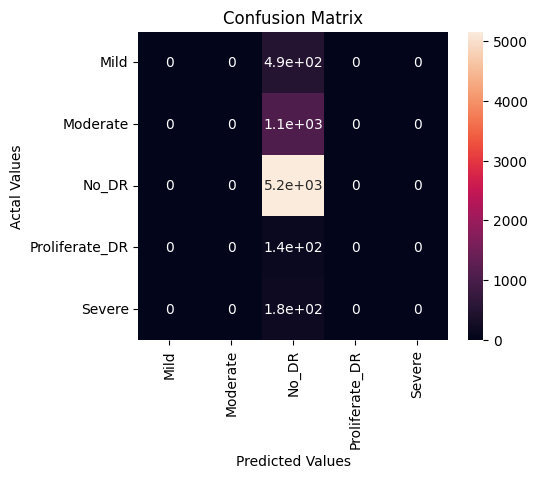

In [44]:
cm(y_true, y_preds_alexnet)

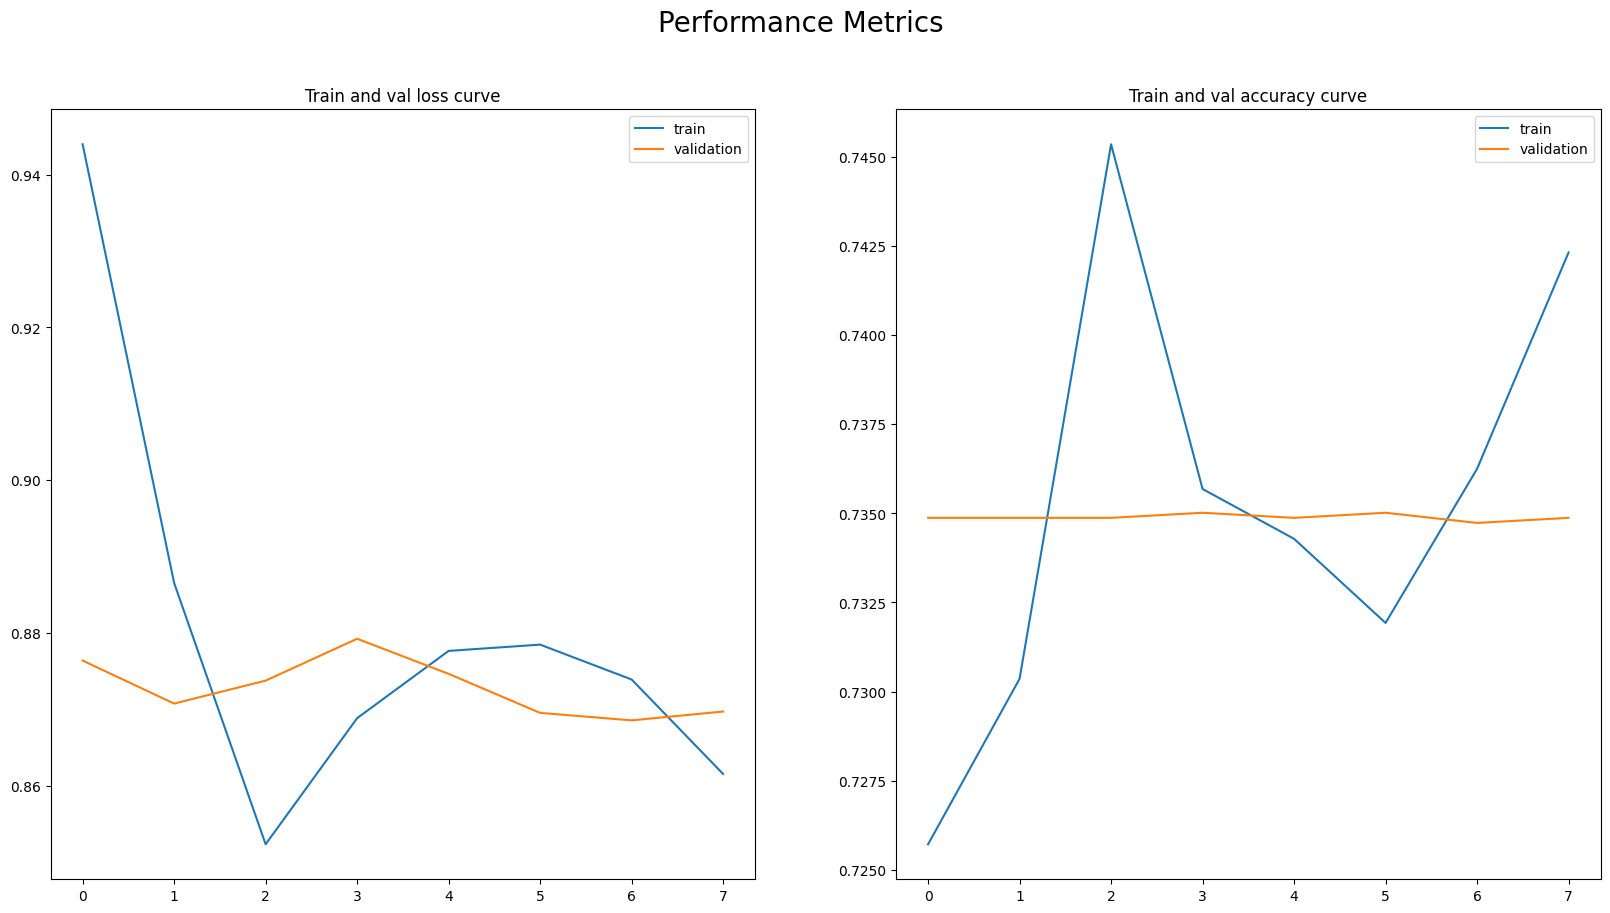

In [45]:
# Performance metrics for AlexNet
plot_result(model_alexnet_history)

2. DenseNet

In [46]:
# Basic architecture of DenseNet
model_densenet=DenseNet121(weights='imagenet',include_top=False, input_shape=(224, 224, 3)) 
x=model_densenet.output
x= Flatten()(x)
x= Dense(1024, activation='relu')(x)
x= Dense(512, activation='relu')(x)
x= Dropout(0.5)(x)
output=Dense(len(classes),activation='softmax')(x) #FC-layer
model_denseNet=tf.keras.Model(inputs=model_densenet.input,outputs=output)

In [47]:
# Summary of the denseNet model
model_denseNet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [48]:
# Freezing the base model
for layer in model_denseNet.layers[:-5]:
    layer.trainable=False

In [50]:
model_denseNet_history = train_model(model_denseNet)

Epoch 1/10
175/175 [==============================] - 821s 5s/step - loss: 1.0513 - accuracy: 0.7254 - val_loss: 0.8619 - val_accuracy: 0.7346
Epoch 2/10
175/175 [==============================] - 811s 5s/step - loss: 1.0384 - accuracy: 0.7318 - val_loss: 0.8894 - val_accuracy: 0.7346
Epoch 3/10
175/175 [==============================] - 826s 5s/step - loss: 0.9785 - accuracy: 0.7276 - val_loss: 0.8515 - val_accuracy: 0.7353
Epoch 4/10
175/175 [==============================] - 799s 5s/step - loss: 0.9306 - accuracy: 0.7404 - val_loss: 0.8378 - val_accuracy: 0.7350
Epoch 5/10
175/175 [==============================] - 798s 5s/step - loss: 0.9310 - accuracy: 0.7300 - val_loss: 0.8428 - val_accuracy: 0.7343
Epoch 6/10
175/175 [==============================] - 800s 5s/step - loss: 0.9127 - accuracy: 0.7359 - val_loss: 0.8590 - val_accuracy: 0.7349
Epoch 7/10
175/175 [==============================] - 799s 5s/step - loss: 0.9121 - accuracy: 0.7330 - val_loss: 0.8904 - val_accuracy: 0.7350

In [51]:
model_denseNet.save('model_densenet_wiener_clahe_g.h5')

In [52]:
# Evaluation metrics for denseNet model
model_denseNet_result = model_denseNet.evaluate(valid_data, batch_size=32)
model_denseNet_result

220/220 [==============================] - 392s 2s/step - loss: 0.8994 - accuracy: 0.7348


[0.8993648290634155, 0.7347665429115295]

In [53]:
y_preds_model_denseNet = make_predictions(model_denseNet)

220/220 [==============================] - 393s 2s/step


In [54]:
# Metrics for denseNet
metrics(y_true, y_preds_model_denseNet)

C:\Users\sanje\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sanje\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sanje\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344

(            class  sensitivity  specificity
 0            Mild          1.0          0.0
 1        Moderate          1.0          0.0
 2           No_DR          0.0          1.0
 3  Proliferate_DR          1.0          0.0
 4          Severe          1.0          0.0,
 0.7347665148063781)

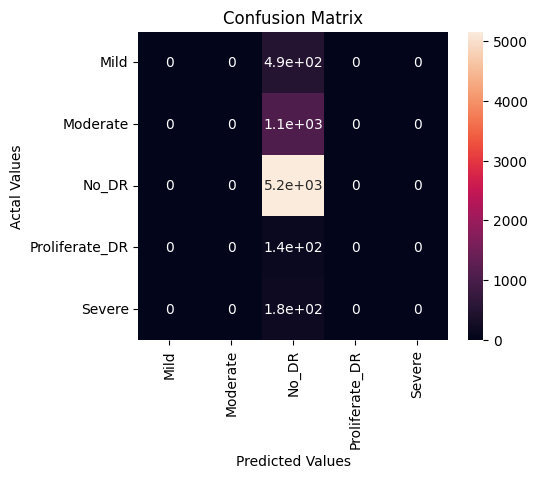

In [55]:
# Confusion Matrix
cm(y_true, y_preds_model_denseNet)

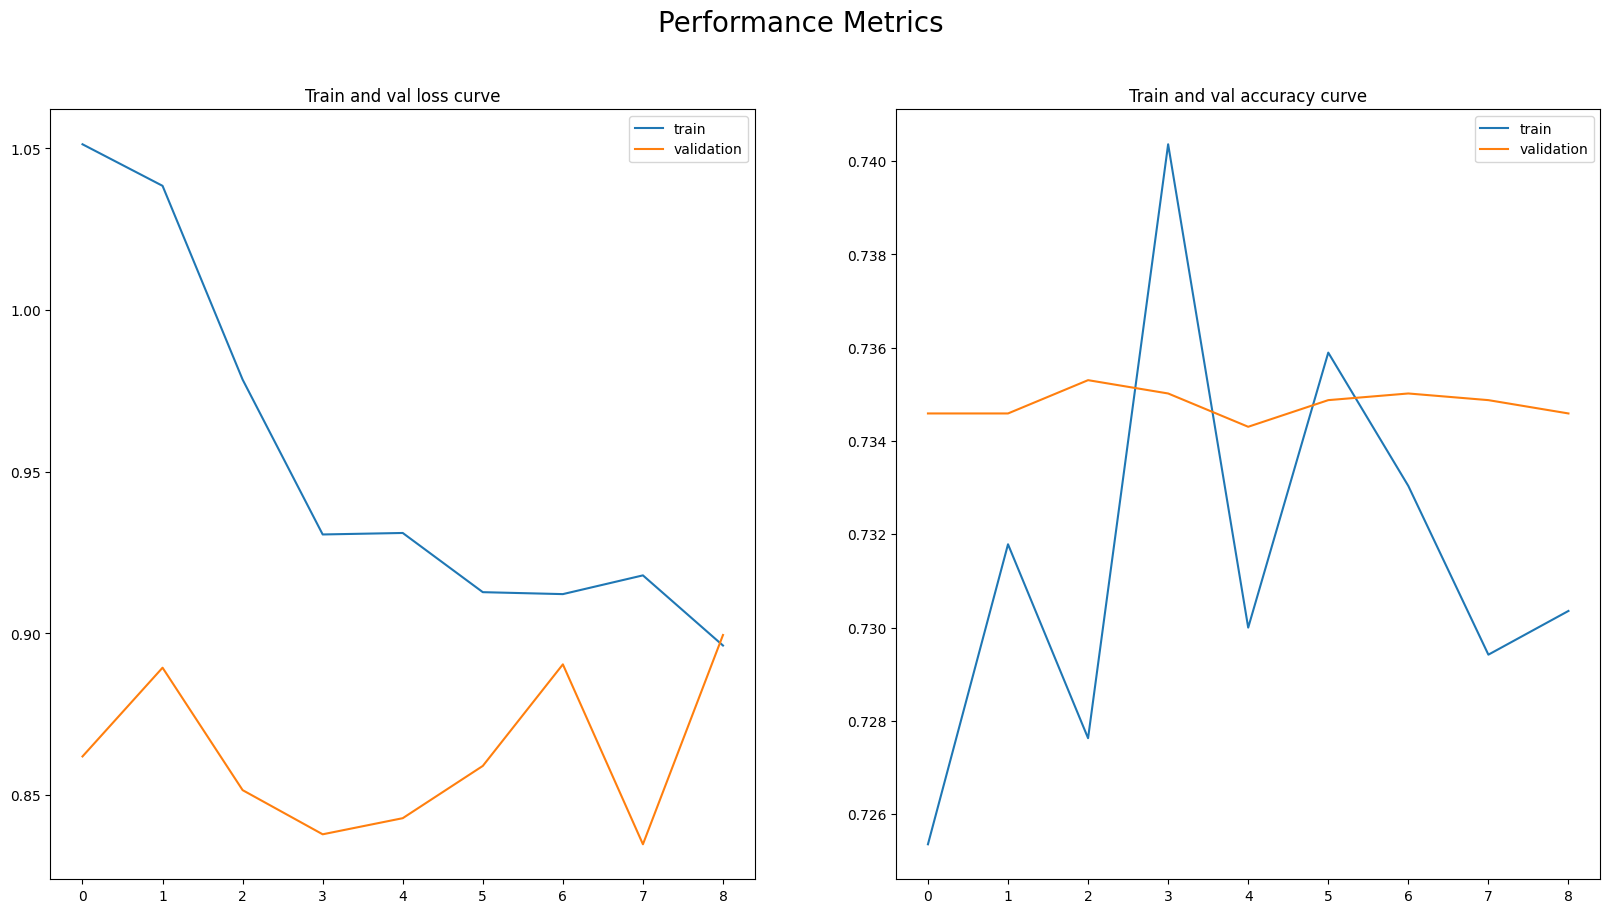

In [56]:
# Visualizing the evaluation metrics
plot_result(model_denseNet_history)

3. ResNet50

In [57]:
# Basic architecture model of ResNet50
model_resnet50=ResNet50(weights='imagenet',include_top=False, input_shape=(224, 224, 3)) 
x=model_resnet50.output
x= GlobalMaxPooling2D()(x)
x= BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x= Dropout(0.5)(x)
output=Dense(len(classes),activation='softmax')(x) #FC-layer
model_resNet=tf.keras.Model(inputs=model_resnet50.input,outputs=output)

In [58]:
# Summary of the ResNet50 model
model_resNet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [59]:
# Freezing the base model
for layer in model_resNet.layers[:-5]:
    layer.trainable=False

In [60]:
model_resNet_history = train_model(model_resNet)

Epoch 1/10
175/175 [==============================] - 632s 4s/step - loss: 1.3135 - accuracy: 0.6525 - val_loss: 0.9371 - val_accuracy: 0.7246
Epoch 2/10
175/175 [==============================] - 6225s 36s/step - loss: 1.0045 - accuracy: 0.7098 - val_loss: 0.8816 - val_accuracy: 0.7350
Epoch 3/10
175/175 [==============================] - 608s 3s/step - loss: 0.9334 - accuracy: 0.7350 - val_loss: 0.8746 - val_accuracy: 0.7346
Epoch 4/10
175/175 [==============================] - 1625s 9s/step - loss: 0.9236 - accuracy: 0.7309 - val_loss: 0.9096 - val_accuracy: 0.7349
Epoch 5/10
175/175 [==============================] - 616s 4s/step - loss: 0.9066 - accuracy: 0.7332 - val_loss: 0.8728 - val_accuracy: 0.7346
Epoch 6/10
175/175 [==============================] - 615s 4s/step - loss: 0.8861 - accuracy: 0.7357 - val_loss: 0.8613 - val_accuracy: 0.7350
Epoch 7/10
175/175 [==============================] - 624s 4s/step - loss: 0.8868 - accuracy: 0.7398 - val_loss: 0.8596 - val_accuracy: 0.7

In [61]:
model_resNet.save('model_resnet_wiener_clahe_g.h5')

In [62]:
y_preds_resNet = make_predictions(model_resNet)

220/220 [==============================] - 356s 2s/step


In [63]:
# Evaluation metrics for resNet model
model_resNet_result = model_resNet.evaluate(valid_data, batch_size=32)
model_resNet_result

220/220 [==============================] - 339s 2s/step - loss: 0.8658 - accuracy: 0.7348


[0.8657711744308472, 0.7347665429115295]

In [64]:
# Evaluation metrics for resNet
metrics(y_true, y_preds_resNet)

C:\Users\sanje\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sanje\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sanje\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344

(            class  sensitivity  specificity
 0            Mild          1.0          0.0
 1        Moderate          1.0          0.0
 2           No_DR          0.0          1.0
 3  Proliferate_DR          1.0          0.0
 4          Severe          1.0          0.0,
 0.7347665148063781)

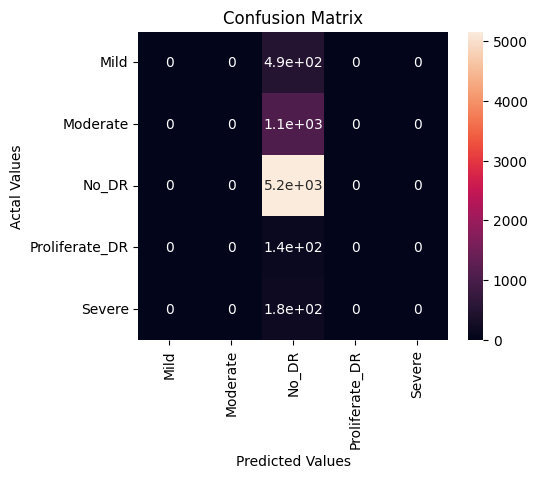

In [65]:
# Confusion matrix
cm(y_true, y_preds_resNet)

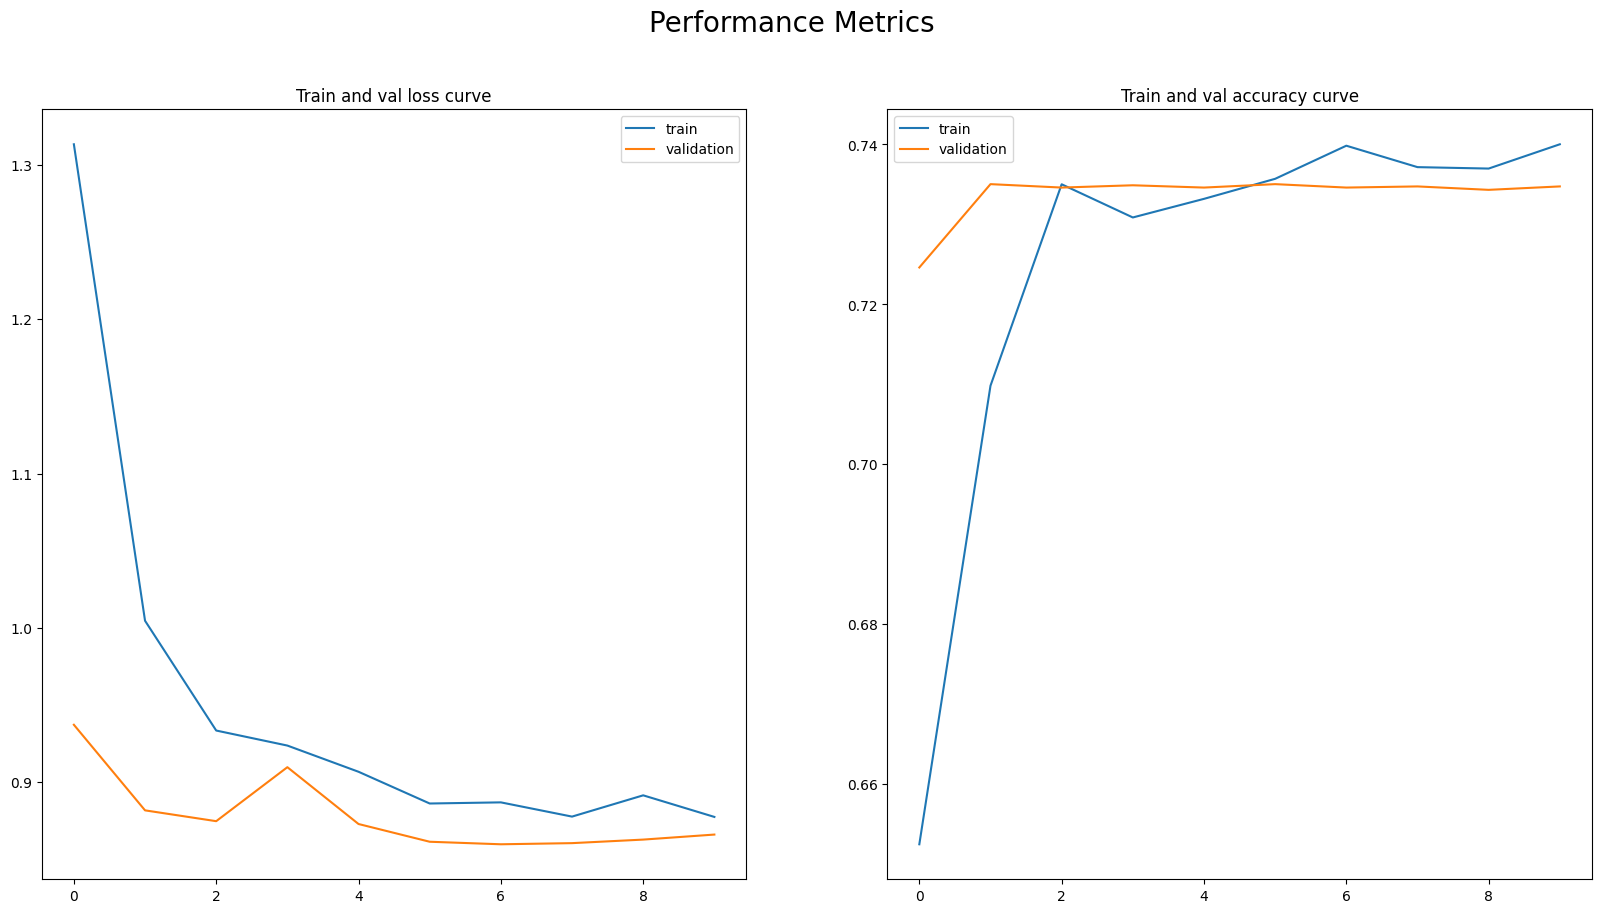

In [66]:
# Visualizing the evaluation metrics
plot_result(model_resNet_history)

4. InceptionV3

In [ ]:
# Basic architecture model of InceptionV3
model_inception=InceptionV3(weights='imagenet',include_top=False, input_shape=(224, 224, 3)) 
x=model_inception.output
x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x= Dropout(0.5)(x)
output=Dense(len(classes),activation='softmax')(x) #FC-layer
model_inceptionV3=tf.keras.Model(inputs=model_inception.input,outputs=output)

In [ ]:
# Summary of InceptionV3
model_inceptionV3.summary()

In [ ]:
# Freezing the base model
for layer in model_inceptionV3.layers[:-5]:
    layer.trainable=False

In [ ]:
model_inception_history = train_model(model_inceptionV3)

In [ ]:
model_inceptionV3.save('model_inceptionv3_wiener_clahe_g.h5')

In [ ]:
y_preds_inceptionV3 = make_predictions(model_inceptionV3)

In [ ]:
# Evaluation metrics for inception model
model_inception_result = model_inceptionV3.evaluate(valid_data, batch_size=32)
model_inception_result

In [ ]:
# Evaluation metrics for InceptionV3
metrics(y_true, y_preds_inceptionV3)

In [ ]:
# confusion matrix for inceptionV3
cm(y_true, y_preds_inceptionV3)

In [ ]:
# Visualizing the evaluation metrics
plot_result(model_inception_history)

5. VGG-16

In [ ]:
# Basic architecture model of VGG16
model_vgg=VGG16(weights='imagenet',include_top=False, input_shape=(224, 224, 3)) 
x=model_vgg.output
x= GlobalAveragePooling2D()(x)
x= Dense(256, activation='relu')(x)
x= Dropout(0.5)(x)
output=Dense(len(classes),activation='softmax')(x) #FC-layer
model_vgg=tf.keras.Model(inputs=model_vgg.input,outputs=output)

In [ ]:
# Summary of VGG16 model
model_vgg.summary()

In [ ]:
# Freezing the base model
for layer in model_vgg.layers[:-5]:
    layer.trainable=False

In [ ]:
model_vgg_history = train_model(model_vgg)

In [ ]:
# Evaluation metrics for InceptionV3 model
model_vgg_result = model_vgg.evaluate(valid_data, batch_size=32)
model_vgg_result

In [ ]:
model_vgg.save('model_vgg16_wiener_clahe_g.h5')

In [ ]:
y_preds_model_vgg = make_predictions(model_vgg)

In [ ]:
# Evaluate metrics for VGG16
metrics(y_true, y_preds_model_vgg)

In [ ]:
cm(y_true, y_preds_model_vgg)

In [ ]:
# Visualizing the evaluation metrics
plot_result(model_vgg_history)

Plotting predictions on Test Dataset

In [67]:
model_names=["AlexNet", "DenseNet121", "ResNet50"]

In [68]:
model_alexnet_results

[0.8698059916496277, 0.7347665429115295]

In [ ]:
x = metrics(y_true, y_preds_model_vgg)
x[0]['Mild']['sensitivity']

In [70]:
predictions = [y_preds_alexnet, y_preds_model_denseNet, y_preds_resNet]
acc = []
sns = pd.DataFrame(index=classes, columns=model_names)
spc = pd.DataFrame(index=classes, columns=model_names)
for i in range(len(predictions)):
    x = metrics(y_true, predictions[i])
    acc.append((model_names[i], x[1]))
    for j in range(5):
        sns[model_names[i]][classes[j]] = np.float32(x[0][x[0]['class']==classes[j]]['sensitivity'])[0]
        spc[model_names[i]][classes[j]] = np.float32(x[0][x[0]['class']==classes[j]]['specificity'])[0]
acc, sns, spc;

C:\Users\sanje\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sanje\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sanje\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344

In [71]:
# Specificity
spc

AlexNet DenseNet121 ResNet50
Mild               0.0         0.0      0.0
Moderate           0.0         0.0      0.0
No_DR              1.0         1.0      1.0
Proliferate_DR     0.0         0.0      0.0
Severe             0.0         0.0      0.0

In [72]:
# Sensitivity
sns

AlexNet DenseNet121 ResNet50
Mild               1.0         1.0      1.0
Moderate           1.0         1.0      1.0
No_DR              0.0         0.0      0.0
Proliferate_DR     1.0         1.0      1.0
Severe             1.0         1.0      1.0

In [73]:
accuracy = pd.DataFrame(acc, columns=["model", "accuracy"])
accuracy

model  accuracy
0      AlexNet  0.734767
1  DenseNet121  0.734767
2     ResNet50  0.734767

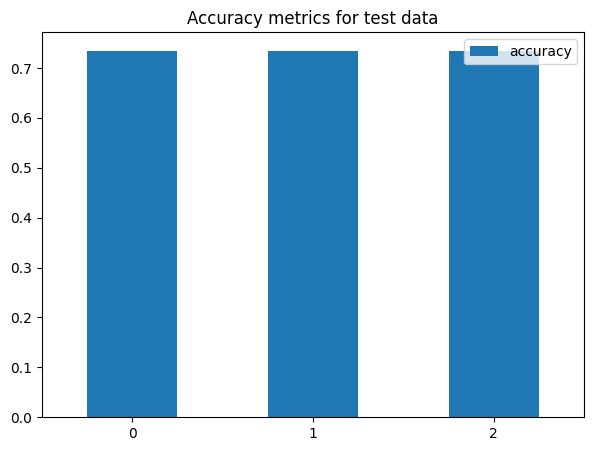

In [74]:
# Plotting the accuracy
accuracy.plot(kind='bar', figsize=(7, 5), rot=0, title="Accuracy metrics for test data");

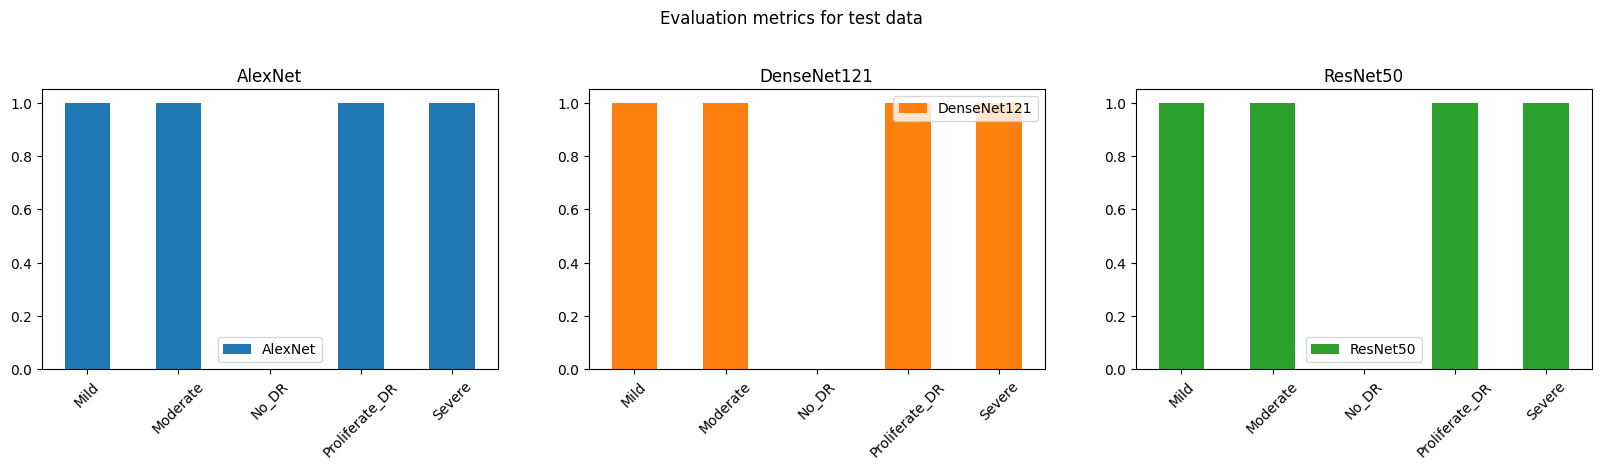

In [75]:
# Plotting the sensitivity
sns.plot(kind='bar', subplots=True, layout=(2, 3), figsize=(20, 8), rot=45, title="Evaluation metrics for test data");